# Installation of dependencies

In [1]:
pip install gemmi wget matplotlib tqdm ipywidgets

Note: you may need to restart the kernel to use updated packages.


# PDB mirror update (structures only)

In [2]:
%%sh

MIRRORDIR=/home/olico/repositories/mmCIF_PDB
LOGFILE=/home/olico/repositories/mmCIF_PDB_`date +"%Y-%m-%d"`.log
RSYNC=rsync
echo "Log file: " $LOGFILE
SERVER=rsync.ebi.ac.uk::pub/databases/pdb
PORT=873

mkdir -p $MIRRORDIR

${RSYNC} -rlpt -v -z --delete --port=$PORT ${SERVER}/data/structures/divided/mmCIF/ $MIRRORDIR > $LOGFILE 2>/dev/null
echo "finished" 

Log file:  /home/olico/repositories/mmCIF_PDB_2025-07-02.log
finished


# Reading all structures

In [4]:
import gemmi
from tqdm.notebook import tqdm

loaded_count = 0
failed_count = 0

for file_path in tqdm(gemmi.CoorFileWalk("/home/olico/repositories/mmCIF_PDB")) :
  try:
    structure = gemmi.read_structure(file_path)
    loaded_count += 1
  except Exception as e:
    print(f"Failed: {file_path} | Error: {e}")
    failed_count += 1

# prints it without running out of memory
print(f"\n Done! Loaded {loaded_count} files, Failed {failed_count} files")

print(f"Summary: Loaded {loaded_count} files, Failed {failed_count} files")


0it [00:00, ?it/s]

Failed: /home/olico/repositories/mmCIF_PDB/ol/5olg.cif.gz | Error: not an integer: 
Failed: /home/olico/repositories/mmCIF_PDB/pv/7pvv.cif.gz | Error: not an integer: 

✅ Done! Loaded 238266 files, Failed 2 files
Summary: Loaded 238266 files, Failed 2 files


# Disulfide bonds

In [4]:
import gemmi
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import numpy as np 

# list to store disulfide bond distances
disulfide_lengths = []

# counter for failures
failed_count = 0

# loop through structure files
for path in tqdm(gemmi.CoorFileWalk("/home/olico/repositories/mmCIF_PDB")):
    try:
        structure = gemmi.read_structure(path)

        # get bond annotations 
        conn_list = structure.connections
        for conn in conn_list:
            if conn.type == gemmi.ConnectionType.Disulf:
                # save bond length
                disulfide_lengths.append(conn.reported_distance)

                # printing updates on bonds found to show its working
                if len(disulfide_lengths) % 10000 == 0:
                    print(f"{len(disulfide_lengths)} disulfide bonds found so far...")

    except Exception as e:
        print(f"Failed: {path} | Error: {e}")
        failed_count += 1

print(f"Done! Found {len(disulfide_lengths)} disulfide bonds across PDB. Failed files: {failed_count}")


0it [00:00, ?it/s]

10000 disulfide bonds found so far...
20000 disulfide bonds found so far...
30000 disulfide bonds found so far...
40000 disulfide bonds found so far...
50000 disulfide bonds found so far...
60000 disulfide bonds found so far...
70000 disulfide bonds found so far...
80000 disulfide bonds found so far...
90000 disulfide bonds found so far...
100000 disulfide bonds found so far...
110000 disulfide bonds found so far...
120000 disulfide bonds found so far...
130000 disulfide bonds found so far...
140000 disulfide bonds found so far...
150000 disulfide bonds found so far...
160000 disulfide bonds found so far...
170000 disulfide bonds found so far...
180000 disulfide bonds found so far...
190000 disulfide bonds found so far...
200000 disulfide bonds found so far...
210000 disulfide bonds found so far...
220000 disulfide bonds found so far...
230000 disulfide bonds found so far...
240000 disulfide bonds found so far...
Failed: /home/olico/repositories/mmCIF_PDB/ol/5olg.cif.gz | Error: not an

# Plotting histogram of disulfide bonds

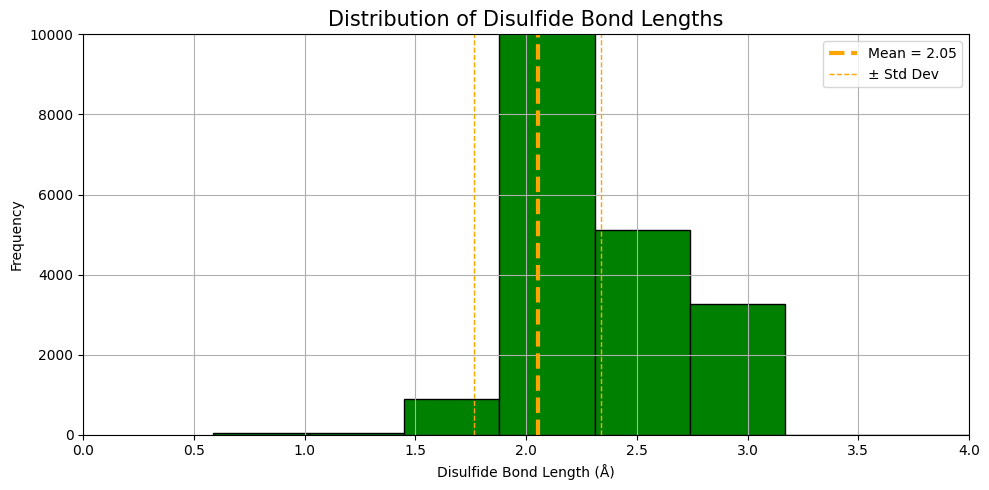

0.587
129.739


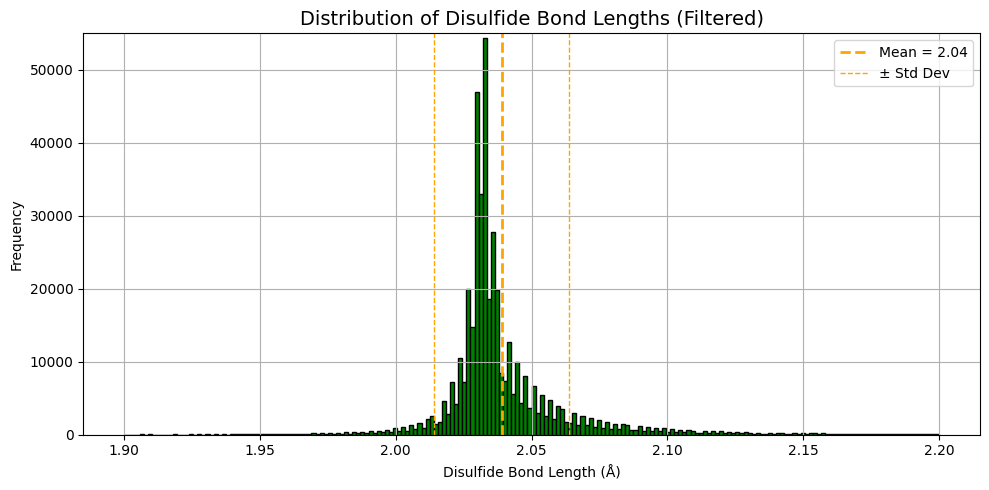

Filtered disulfide bonds (1.9–2.2 Å): 433997
Total disulfide bonds found: 446277


In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

plt.title("Distribution of Disulfide Bond Lengths", fontsize=15)
plt.hist(disulfide_lengths, bins=300, color='green', edgecolor='black')

# calculate mean and std
mean = np.mean(disulfide_lengths)
std = np.std(disulfide_lengths)

# add mean and std to plot 
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=3, label=f'Mean = {mean:.2f}')
plt.axvline(mean - std, color='orange', linestyle='dashed', linewidth=1, label=f'± Std Dev')
plt.axvline(mean + std, color='orange', linestyle='dashed', linewidth=1)

plt.xlabel("Disulfide Bond Length (Å)")
plt.ylabel("Frequency")

# Set axis ranges
plt.xlim(0, 4) 
plt.ylim(0, 10000)  

plt.legend()
plt.grid(True)
plt.tight_layout()

# save
plt.savefig('anomalous_bonds_histogram.png')

plt.show()


print(min(disulfide_lengths))
print(max(disulfide_lengths))
# shows the min length is 0.587 and the max is 129.739 = outliers

# filtering data so histogram is not a block
filtered_bonds = [d for d in disulfide_lengths if 1.9 <= d <= 2.2]

# calculate mean and std
mean = np.mean(filtered_bonds)
std = np.std(filtered_bonds)

plt.figure(figsize=(10, 5))
plt.hist(filtered_bonds, bins=200, color='green', edgecolor='black')

# Add mean and std
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Mean = {mean:.2f}')
plt.axvline(mean - std, color='orange', linestyle='dashed', linewidth=1, label='± Std Dev')
plt.axvline(mean + std, color='orange', linestyle='dashed', linewidth=1)

plt.title("Distribution of Disulfide Bond Lengths (Filtered)", fontsize=14)
plt.xlabel("Disulfide Bond Length (Å)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 55000)
plt.show()

# how many disulfide bonds are in the filter
print(f"Filtered disulfide bonds (1.9–2.2 Å): {len(filtered_bonds)}")

# how many disulfide bonds are there altogether
print(f"Total disulfide bonds found: {len(disulfide_lengths)}")



# Making a dictionary and list of anomalous disulfide bonds

In [3]:
import gemmi
import json
from tqdm.notebook import tqdm

anomalous_disulfides = []
failed_count = 0

# extract disulfide bonds
for path in tqdm(gemmi.CoorFileWalk("/home/olico/repositories/mmCIF_PDB")): 
    try:
        structure = gemmi.read_structure(path)
        conn_list = structure.connections
        pdb_id = structure.name.upper()

        for conn in conn_list:
            if conn.type == gemmi.ConnectionType.Disulf:
                if conn.reported_distance < 1.9 or conn.reported_distance > 2.2:
                    bond = {
                        "pdb_id": pdb_id,
                        "resolution" : structure.resolution,
                        "residue1": {
                            "chain"  : conn.partner1.chain_name,
                            "residue": conn.partner1.res_id.name,
                            "number" : str (conn.partner1.res_id.seqid),
                            "atom"   : conn.partner1.atom_name                            
                        },
                        "residue2": {
                            "chain"  : conn.partner2.chain_name,
                            "residue": conn.partner2.res_id.name,
                            "number" : str (conn.partner2.res_id.seqid),
                            "atom"   : conn.partner2.atom_name
                        },
                        "distance": conn.reported_distance
                    }
                    anomalous_disulfides.append(bond)

                    if len(anomalous_disulfides) % 1000 == 0:
                        print(f"{len(anomalous_disulfides)} disulfide anomalies found so far...")



    except Exception as e:
        print(f"Failed: {path} | Error: {e}")
        failed_count += 1

# Save to JSON
with open("anomalous_disulfides.json", "w") as f:
    json.dump(anomalous_disulfides, f, indent=2)

print("Done!")
print(f"Total anomalous disulfide bonds: {len(anomalous_disulfides)}")
print(f"Failed counts: {failed_count}")

0it [00:00, ?it/s]

1000 disulfide anomalies found so far...
2000 disulfide anomalies found so far...
3000 disulfide anomalies found so far...
4000 disulfide anomalies found so far...
5000 disulfide anomalies found so far...
6000 disulfide anomalies found so far...
Failed: /home/olico/repositories/mmCIF_PDB/ol/5olg.cif.gz | Error: not an integer: 
7000 disulfide anomalies found so far...
Failed: /home/olico/repositories/mmCIF_PDB/pv/7pvv.cif.gz | Error: not an integer: 
8000 disulfide anomalies found so far...
9000 disulfide anomalies found so far...
10000 disulfide anomalies found so far...
11000 disulfide anomalies found so far...
12000 disulfide anomalies found so far...
Done!
Total anomalous disulfide bonds: 12280
Failed counts: 2


# Making a table for anomalous disulfide bonds

In [4]:
import pandas as pd

table_data = [
    {
        "pdb_id": bond["pdb_id"],
        "resolution": bond["resolution"],
        "chain1": bond["residue1"]["chain"],
        "res1": bond["residue1"]["residue"],
        "resnum1": bond["residue1"]["number"],
        "atom1": bond["residue1"]["atom"],
        "chain2": bond["residue2"]["chain"],
        "res2": bond["residue2"]["residue"],
        "resnum2": bond["residue2"]["number"],
        "atom2": bond["residue2"]["atom"],
        "distance": bond["distance"]
    }
    for bond in anomalous_disulfides
]

# Create dataframe and save to CSV
df = pd.DataFrame(table_data)
df.to_csv("anomalous_disulfides_table.csv", index=False)

print("Table saved as anomalous_disulfides_table.csv")

Table saved as anomalous_disulfides_table.csv


# Making a JSON file for multiple conformation anomalies

In [25]:
import gemmi
import json
import os
from tqdm.notebook import tqdm

# Load anomalies
with open("anomalous_disulfides.json") as f:
    anomalies = json.load(f)

filtered_anomalies = []

for entry in tqdm(anomalies):
    # Skip if resolution is 0 or > 2.0 Å
    if entry["resolution"] is None or entry["resolution"] == 0 or entry["resolution"] >= 2.0:
        continue

    pdb_id = entry["pdb_id"].lower()
    folder = pdb_id[1:3]
    file_path = f"/home/olico/repositories/mmCIF_PDB/{folder}/{pdb_id}.cif.gz"

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    try:
        structure = gemmi.read_structure(file_path)
        model = structure[0]

        chain1 = model[entry["residue1"]["chain"]]
        chain2 = model[entry["residue2"]["chain"]]


        # Find residue 1 
        res1 = None
        for res in chain1:
            if str(res.seqid.num) == entry["residue1"]["number"]:
                res1 = res
                break

        res2 = None
        for res in chain2:
            if str(res.seqid.num) == entry["residue2"]["number"]:
                res2 = res
                break

        if res1 is None or res2 is None:
            print(f"Missing residue in {pdb_id}")
            continue

        atom1_name = entry["residue1"]["atom"].strip()
        atom2_name = entry["residue2"]["atom"].strip()

        # Collect altloc identifiers for atoms matching the atom name
        altlocs1 = {atom.altloc for atom in res1 if atom.name == atom1_name}
        altlocs2 = {atom.altloc for atom in res2 if atom.name == atom2_name}

        # Remove empty altlocs ('' means no alternate conformation)
        altlocs1.discard('')
        altlocs2.discard('')

        # Discard the null character '\x00'
        altlocs1.discard('\x00') 
        altlocs2.discard('\x00') 

        # Keep entry if either atom has alternate conformations
        if altlocs1 or altlocs2:
            filtered_anomalies.append(entry)

    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")

print(f"Found {len(filtered_anomalies)} anomalies with alternate conformations under 2Å resolution.")

# Save 
with open("filtered_altconf_anomalies.json", "w") as f_out:
    json.dump(filtered_anomalies, f_out, indent=2)

  0%|          | 0/12280 [00:00<?, ?it/s]

Missing residue in 1deu
Missing residue in 1deu
Missing residue in 7kn5
Missing residue in 1mhw
Missing residue in 1mhw
Missing residue in 1tal
Missing residue in 2ull
Missing residue in 3urc
Missing residue in 3ure
Missing residue in 3ure
Found 692 anomalies with alternate conformations under 2Å resolution.


# Checking Altlocs and Occupancies

In [2]:
import gemmi
import json
import os
from tqdm.notebook import tqdm

# Load multiple conformation anomalies 
with open("filtered_altconf_anomalies.json") as f:
    anomalies = json.load(f)

# Modify list
occupancy_anomalies = []

for entry in tqdm(anomalies):
    pdb_id = entry["pdb_id"].lower()
    folder = pdb_id[1:3]
    file_path = f"/home/olico/repositories/mmCIF_PDB/{folder}/{pdb_id}.cif.gz"


    if not os.path.exists(file_path):
        print(f"File not found for {pdb_id}: {file_path}")
        continue

    try:
        structure = gemmi.read_structure(file_path)
        model = structure[0]

        # Extract details 
        chain1_id = entry["residue1"]["chain"]
        res1_num = entry["residue1"]["number"]
        atom1_name = entry["residue1"]["atom"].strip()

        chain2_id = entry["residue2"]["chain"]
        res2_num = entry["residue2"]["number"]
        atom2_name = entry["residue2"]["atom"].strip()

        chain1 = model[chain1_id]
        chain2 = model[chain2_id]
        
        # Find residue 1
        res1 = next((res for res in chain1 if str(res.seqid.num) == res1_num), None)
        # Find residue 2
        res2 = next((res for res in chain2 if str(res.seqid.num) == res2_num), None)

        if res1 is None or res2 is None:
            print(f"Residue missing for {pdb_id}. Skipping.")
            continue

        
        # Collect altloc and occupancy for atom 1
        atom1_details = []
        for atom in res1:
            if atom.name == atom1_name:
                # Discard empty string and null character 
                if atom.altloc and atom.altloc != '\x00':
                    atom1_details.append({
                        "altloc": atom.altloc,
                        "occ": round(atom.occ, 3)
                    })
                # record occupancy for atoms with no altlocs 
                elif not atom.altloc:
                    atom1_details.append({
                        "altloc": '',
                        "occ": round(atom.occ, 3)
                    })
        
        # Collect altloc and occupancy for atom 2
        atom2_details = []
        for atom in res2:
            if atom.name == atom2_name:
                if atom.altloc and atom.altloc != '\x00':
                    atom2_details.append({
                        "altloc": atom.altloc,
                        "occ": round(atom.occ, 3)
                    })
                elif not atom.altloc:
                     atom2_details.append({
                        "altloc": '',
                        "occ": round(atom.occ, 3)
                    })

        # Adjust the original list
        entry["residue1"]["altloc_details"] = atom1_details
        entry["residue2"]["altloc_details"] = atom2_details
        
        occupancy_anomalies.append(entry)

    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")

print(f"Successfully adjusted {len(occupancy_anomalies)} anomalies.")

# Save the adjusted anomalies
with open("altloc_occupancy_anomalies.json", "w") as f_out:
    json.dump(occupancy_anomalies, f_out, indent=2)

  0%|          | 0/692 [00:00<?, ?it/s]

Successfully adjusted 692 anomalies.


# Neighbour search 

In [31]:
import gemmi
import json
import os
from tqdm.notebook import tqdm

# The search radius for Gemmi's NeighborSearch
SEARCH_RADIUS_ANGSTROMS = 3.5

# Distance range for a disulfide bond
DISULFIDE_DISTANCE_MIN = 1.9
DISULFIDE_DISTANCE_MAX = 2.2

# Ensure altloc is a clean string for JSON output
def get_clean_altloc(altloc_char):
    if altloc_char and altloc_char != '\x00':
        return altloc_char
    return ''

with open("altloc_occupancy_anomalies.json", "r") as f:
    anomalies = json.load(f)

disulfide_suggestions = []

for entry in tqdm(anomalies):
    pdb_id = entry["pdb_id"].lower()
    folder = pdb_id[1:3]
    file_path = f"/home/olico/repositories/mmCIF_PDB/{folder}/{pdb_id}.cif.gz"

    if not os.path.exists(file_path):
        print(f"File not found for {pdb_id}: {file_path}. Skipping.")
        continue

    try:
        structure = gemmi.read_structure(file_path)
        model = structure[0]
        
        ns = gemmi.NeighborSearch(model, structure.cell, SEARCH_RADIUS_ANGSTROMS).populate(include_h=False)
        
        best_suggestion = None
        min_distance = float('inf')
        
        res1_info = entry["residue1"]
        res1_chain_id = res1_info["chain"]
        res1_num_str = res1_info["number"]
        res1_atom_name = res1_info["atom"].strip()

        res2_info = entry["residue2"]
        res2_chain_id = res2_info["chain"]
        res2_num_str = res2_info["number"]
        res2_atom_name = res2_info["atom"].strip()
        
        # Find and process first SG atom 
        res1_obj = next((res for res in model[res1_chain_id] if str(res.seqid.num) == res1_num_str), None)
        if res1_obj:
            for atom1 in res1_obj:
                if atom1.name == res1_atom_name:
                    hits = ns.find_atoms(atom1.pos, '\0', min_dist=0.1, radius=SEARCH_RADIUS_ANGSTROMS)
                    
                    for hit in hits:
                        cra = hit.to_cra(model)
                        hit_atom = cra.atom
                        hit_chain = cra.chain
                        hit_res = cra.residue
                        
                        if hit_atom.name == 'SG' and not (
                            hit_chain.name == res1_chain_id and
                            str(hit_res.seqid.num) == res1_num_str
                        ):
                            distance_sq = (
                                (atom1.pos.x - hit_atom.pos.x)**2 +
                                (atom1.pos.y - hit_atom.pos.y)**2 +
                                (atom1.pos.z - hit_atom.pos.z)**2
                            )
                            distance = distance_sq**0.5
                            
                            if DISULFIDE_DISTANCE_MIN <= distance < DISULFIDE_DISTANCE_MAX:
                                if distance < min_distance:
                                    min_distance = distance
                                    
                                    best_suggestion = {
                                        "res1": {
                                            "chain": res1_chain_id,
                                            "number": res1_num_str,
                                            "atom": res1_atom_name,
                                            "altloc": get_clean_altloc(atom1.altloc)
                                        },
                                        "res2": {
                                            "chain": hit_chain.name,
                                            "number": str(hit_res.seqid.num),
                                            "atom": hit_atom.name,
                                            "altloc": get_clean_altloc(hit_atom.altloc)
                                        },
                                        "distance": round(distance, 2)
                                    }

        # Find and process second SG atom
        res2_obj = next((res for res in model[res2_chain_id] if str(res.seqid.num) == res2_num_str), None)
        if res2_obj:
            for atom2 in res2_obj:
                if atom2.name == res2_atom_name:
                    hits = ns.find_atoms(atom2.pos, '\0', min_dist=0.1, radius=SEARCH_RADIUS_ANGSTROMS)
                    
                    for hit in hits:
                        cra = hit.to_cra(model)
                        hit_atom = cra.atom
                        hit_chain = cra.chain
                        hit_res = cra.residue
                        
                        if hit_atom.name == 'SG' and not (
                            hit_chain.name == res2_chain_id and
                            str(hit_res.seqid.num) == res2_num_str
                        ):
                            distance_sq = (
                                (atom2.pos.x - hit_atom.pos.x)**2 +
                                (atom2.pos.y - hit_atom.pos.y)**2 +
                                (atom2.pos.z - hit_atom.pos.z)**2
                            )
                            distance = distance_sq**0.5
                            
                            if DISULFIDE_DISTANCE_MIN <= distance < DISULFIDE_DISTANCE_MAX:
                                if distance < min_distance:
                                    min_distance = distance
                                    
                                    best_suggestion = {
                                        "res1": {
                                            "chain": res2_chain_id,
                                            "number": res2_num_str,
                                            "atom": res2_atom_name,
                                            "altloc": get_clean_altloc(atom2.altloc)
                                        },
                                        "res2": {
                                            "chain": hit_chain.name,
                                            "number": str(hit_res.seqid.num),
                                            "atom": hit_atom.name,
                                            "altloc": get_clean_altloc(hit_atom.altloc)
                                        },
                                        "distance": round(distance, 2)
                                    }

        # Final output entry
        final_entry = {
            "pdb_id": entry["pdb_id"],
            "resolution": entry["resolution"],
            "original_disulfide": {
                "res1": entry["residue1"],
                "res2": entry["residue2"],
                "distance": round(entry["distance"], 2)
            }
        }

# Adding a notes area for the suggested more suitable cysteines found in the Neighbour Search
        
        if best_suggestion:
            final_entry["suggested_disulfide"] = best_suggestion
            original_dist = round(entry["distance"], 2)
            suggested_dist = best_suggestion["distance"]
            
            sug_res1 = best_suggestion["res1"]
            sug_res2 = best_suggestion["res2"]
            
            final_entry["note"] = (
                f"A better bond was suggested for CYS {sug_res1['chain']}:{sug_res1['number']} "
                f"(altloc {sug_res1['altloc'] if sug_res1['altloc'] else 'non existent'}) with "
                f"CYS {sug_res2['chain']}:{sug_res2['number']} "
                f"(altloc {sug_res2['altloc'] if sug_res2['altloc'] else 'non existent'}), "
                f"resulting in a closer distance of {suggested_dist}A compared to the "
                f"original anomalous distance of {original_dist}A."
            )



        else:
            final_entry["suggested_disulfide"] = {}
            final_entry["note"] = "No suitable partner found within the valid distance range."

        disulfide_suggestions.append(final_entry)

    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")

print(f"Found {len(disulfide_suggestions)} anomalies with neighbor search results.")

with open("disulfide_suggestions.json", "w") as f_out:
    json.dump(disulfide_suggestions, f_out, indent=2)

  0%|          | 0/692 [00:00<?, ?it/s]

Found 692 anomalies with neighbor search results.


# Histogram for suggested disulfides

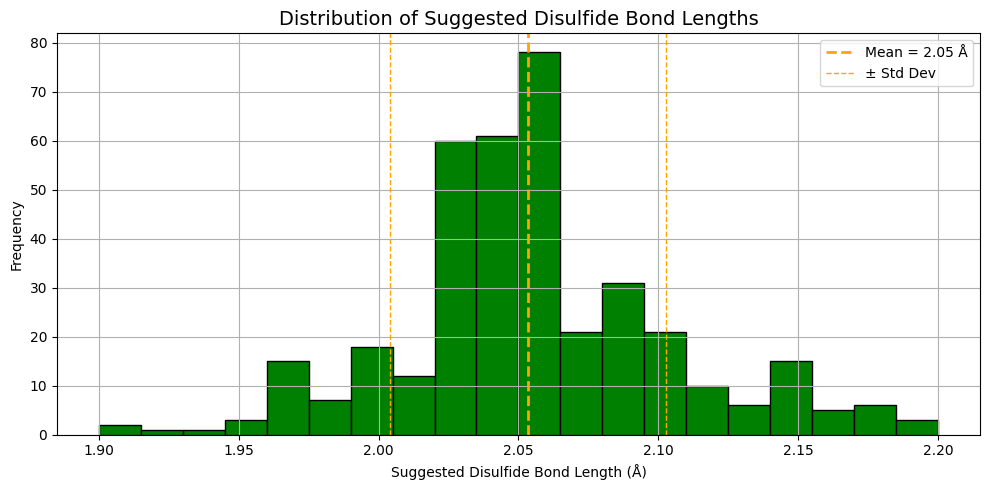

Total suggested bonds: 376
Mean suggested bond length: 2.05 Å
Standard deviation: 0.05 Å


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load JSON file with suggested bonds
with open("disulfide_suggestions.json", "r") as f:
    suggestions_data = json.load(f)

# Extract the distances from the suggested bonds
suggested_distances = []
for entry in suggestions_data:
    if "suggested_disulfide" in entry and entry["suggested_disulfide"]:
        suggested_distances.append(entry["suggested_disulfide"]["distance"])

# Calculate mean and standard deviation for the suggested distances
mean = np.mean(suggested_distances)
std = np.std(suggested_distances)

# Create the histogram
plt.figure(figsize=(10, 5))
plt.hist(suggested_distances, bins=20, color='green', edgecolor='black')

# Add mean and std 
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Mean = {mean:.2f} Å')
plt.axvline(mean - std, color='orange', linestyle='dashed', linewidth=1, label='± Std Dev')
plt.axvline(mean + std, color='orange', linestyle='dashed', linewidth=1)

# Add labels and title
plt.title("Distribution of Suggested Disulfide Bond Lengths", fontsize=14)
plt.xlabel("Suggested Disulfide Bond Length (Å)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()

# save
plt.savefig('suggested_distances_histogram.png')

plt.show()

# Print summary information
print(f"Total suggested bonds: {len(suggested_distances)}")
print(f"Mean suggested bond length: {mean:.2f} Å")
print(f"Standard deviation: {std:.2f} Å")
